## Compute phase masks to produce desired far field
iterative amplitude adjusted Fourier transform (IAAFT)

In [1]:
## general imports
from numpy import *
from numpy.fft import fft,fft2,ifft2,fftshift,ifftshift
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.figure import Figure
from io import BytesIO
from time import time
import random as rand

## local imports
from field_funcs import * # my helper functions

## make the display wide
from IPython.core.display import HTML, display, Image
display(HTML("<style>.container{width:100% !important;}</style>"))

## scaling FFTs

FFTs aren't fit by default for doing transformations of an optical field by a lens, which can be expressed as a phase mask $exp(-i k \mathbf{\rho_2} \cdot \mathbf{\rho_1}/f)$


Fresnel diffraction:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{z} e^{i\frac{k}{2 z} \rho_2^2} \mathfrak{F}\big[ A1(\rho_1) e^{i \frac{k}{2 z}\rho_1^2} \big]_{k_{\perp,1}=\frac{k}{z}\rho_2}
\end{equation*}

Transformation by a lens to a distance z2 from the lens, when the object is in the front focal plane:

\begin{equation*}
    A2(\rho_2) = \frac{-i k}{2 \pi f} \mathfrak{F}\big[ A1(\rho_1) e^{ \frac{-i k}{2 f}\rho_1^2(\frac{z_2}{f} - 1)} \big]_{k_{\perp,1}=\frac{k}{f}\rho_2}
\end{equation*}

2D FFT of some array A1:

\begin{equation*}
    A2_{kl} = \sum_{n=0}^{N-1}\sum_{m=0}^{M-1} A1_{nm} \exp \bigg(\frac{-i 2 \pi k n}{N}\bigg) \exp \bigg(\frac{-i 2 \pi l m}{M}\bigg)
\end{equation*}

where in the FT, the exponential in the integrand looks like $exp\big(-i\frac{k}{z}x_1 x_2\big) exp\big(-i\frac{k}{z}y_1 y_2\big) $, $k = 2\pi/ \lambda$. The input field points are separated in real space by $\delta x_1$, and the spacing between field points in the Fourier plane must be proportional to $\delta x_1$. Taking into account that the resolution in the output field must be inversely proportional the number of input pts making up the field, along with the factors in the exponential above, we deduce that the real space separation of points in the Fourier plane is $k z/(\delta x_1 N)$, with the N the number of pts in dimension x. 


## reproduce ring hologram code
originally from Nathan Lindquist's MATLAB code.

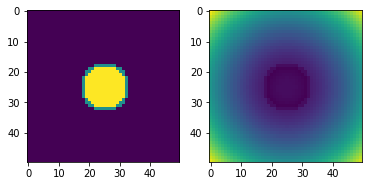

In [117]:
## physics and system params
lmbda = 450
k = 2*pi/lmbda
a = 700 # ring radius
w = 5000 # grid width
pts = 201
xpts = linspace(-w/2, w/2, pts)
ypts = linspace(-w/2, w/2, pts)
xx,yy = meshgrid(xpts,ypts)
rr = sqrt(xx**2 + yy**2)
phi = arctan2(yy,xx)
r_outer = 200 # mask radius outer
r_inner = 170 # " " ...

# hotspot at the origin
dx = dy = 0

sample = zeros((pts,pts))

# skip iterating over dx,dy

# slm phase profile based on donut beam
slm = k*(a - sqrt((xx+dx)**2 + (yy+dy)**2)**2) + phi
# desired amplitude at sample
desampl = (rr < r_outer).astype(float) - (rr > r_inner).astype(float)
# desampl = desampl.astype(float)
# desired phase map
desangl = desampl*slm

fig, axes = plt.subplots(nrows=1,ncols=2)
axes[0].imshow(desampl[75:125,75:125]) # time-average at sample
axes[1].imshow(desangl[75:125,75:125]) # phase map at sample

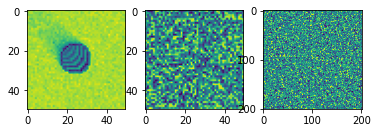

In [118]:
for i in range(100):
       
        # propagate wave to sample
        sample = fftshift(fft2(ifftshift(exp(1j*slm))))
        
        # amplitude of sample
        ampl = abs(sample)
        
        # phase of wave arriving at sample 
        angl = angle(sample)      
        
        # assign desired amplitude to wave at sample
        sample = desampl*exp(1j*angl)
        
        # back-propagate corrected sample profile to slm
        slm = angle(ifftshift(ifft2(fftshift(sample))))
        
fig, axes = plt.subplots(nrows=1,ncols=3)
axes[0].imshow(ampl[75:125,75:125]) # time-average at sample
axes[1].imshow(angl[75:125,75:125]) # phase map at sample
axes[2].imshow(angle(slm)) # slm phase map

## mask from text

In [247]:
def text_to_rgba(s, *, dpi, **kwargs):
    """from matplotlib examples somewhere..."""
    # To convert a text string to an image, we can:
    # - draw it on an empty and transparent figure;
    # - save the figure to a temporary buffer using ``bbox_inches="tight",
    #   pad_inches=0`` which will pick the correct area to save;
    # - load the buffer using ``plt.imread``.
    #
    # (If desired, one can also directly save the image to the filesystem.)
    fig = Figure(facecolor="none")
    fig.text(0, 0, s, **kwargs)
    buf = BytesIO()
    fig.savefig(buf, dpi=dpi, format="png", bbox_inches="tight", pad_inches=0)
    buf.seek(0)
    rgba = plt.imread(buf)
    return rgba

rgb_weights = [0.2989, 0.5870, 0.1140]
gray_image = lambda img: np.dot(img[...,:3], rgb_weights)

def lowres(bitmap,div,xform):
    """
    bitmap: a binary image stored as an array or list
    div: the number of pixels in each dimension to group together
    xform: the function to determine the value to assign to a div x div group of pixels, e.g. lambda x: mean(x).
        must take exactly one argument of type list or array
    
    note: the bitmap copied and then renormalized so pixel values are in [amax(bitmap),1]!
    
    returns an array of the same shape and size of bitmap, but with pixel values replaced by group according to xform
    """    
    ymax,xmax = bitmap.shape
    assert ymax % div == 0, "ymax/div should be an integer"
    assert xmax % div == 0, "xmax/div should be an integer"
    
    img = copy(bitmap)
    img /= amax(img)
    for i in range(ymax//div):
        for j in range(xmax//div):
            img[i*div:(i+1)*div,j*div:(j+1)*div] = xform(img[i*div:(i+1)*div,j*div:(j+1)*div])
    
    return img

### "continuous" phase mask

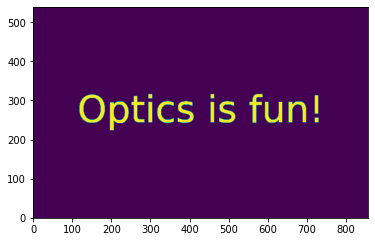

In [3]:
# i want the text to fill up roughly the area of a credit card

mm = 10 # plot resolution of 100 um

xmax = int(85.6*mm)
xmax = xmax + 1 if xmax % 2 else xmax
ymax = int(53.98*mm)
ymax = ymax + 1 if ymax % 2 else ymax
dpi = 25.4*mm
text_img = gray_image(text_to_rgba("Optics is fun!", fontsize=ymax//20, dpi=dpi))
dimy,dimx = text_img.shape
text_img = flip(text_img,0)

# center the text image on a mask of zeros
mask = zeros((ymax,xmax))
mask[ymax//2 - dimy//2:ymax//2 + dimy//2, xmax//2 - dimx//2:xmax//2 + dimx//2+1] = 1-text_img
fig, ax = plt.subplots()
ax.set_xlim((0,xmax))
ax.set_ylim((0,ymax))
ax.imshow(mask)

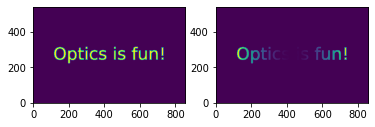

In [6]:
## physics and system params
lmbda = 5.32e-4*mm
k = 2*pi/lmbda
wx = int(xmax+0.5) # grid width
wy = int(ymax+0.5) 
xpts = linspace(-wx/2,wx/2,mask.shape[1])
ypts = linspace(-wy/2,wy/2,mask.shape[0])
xx,yy = meshgrid(xpts,ypts)
rr = sqrt(xx**2 + yy**2)
phi = arctan2(yy,xx)

output = zeros(mask.shape)

# diffractive element phase profile. 
z = 1000*mm
mask_angl = k*sqrt(xx**2 + yy**2)**2/z  # phase factor for Fresnel propagation over a distance z in free space.

# desired amplitude at sample
desampl = mask

# desired phase map; this is not really important for my design plans
desangl = desampl*mask_angl

fig, axes = plt.subplots(nrows=1,ncols=2)
for ax in axes:
    ax.set_xlim((0,xmax))
    ax.set_ylim((0,ymax))
axes[0].imshow(desampl) # time-average at sample
axes[1].imshow(desangl) # phase map at sample

In [19]:
# iterate to get a good phase mask
for i in range(100):
       
    # propagate wave to output
    output = fftshift(fft2(ifftshift(exp(1j*mask_angl))))

    # amplitude of output
    ampl = abs(output)

    # phase of wave arriving at output 
    angl = angle(output)      

    # assign desired amplitude to wave at output
    output = desampl*exp(1j*angl)

    # back-propagate corrected output profile to mask_angl
    mask_angl = angle(ifftshift(ifft2(fftshift(output))))

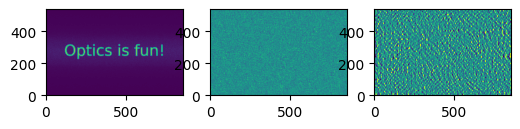

In [20]:
fig, axes = plt.subplots(nrows=1,ncols=3,dpi=100)
for ax in axes:
    ax.set_xlim((0,xmax))
    ax.set_ylim((0,ymax))
cbar0 = axes[0].imshow(ampl) # time-average at output
cbar1 = axes[1].imshow(angl) # phase map at output
cbar2 = axes[2].imshow(angle(mask_angl)) # mask_angl phase map

### binary phase mask
forcing the phase mask to be binary makes the amplitude go to zero in the output. find a better algorithm for this.

28 110


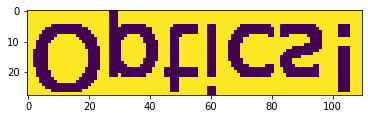

In [236]:
mm = 4 # the plot resolution is over this

xmax = int(80*mm) #86
xmax = xmax + 1 if xmax % 2 else xmax
ymax = int(50*mm) #54
ymax = ymax + 1 if ymax % 2 else ymax
dpi = 25.4*mm
text_img = gray_image(text_to_rgba("Optics!", fontsize=22,dpi=dpi))#ymax//15, dpi=dpi))
dimy,dimx = text_img.shape
print(dimy,dimx)
text_img = flip(text_img,0)
plt.imshow(text_img)

In [ ]:
plt.

In [222]:
ymax//15

13

In [223]:
1.6*50

80.0

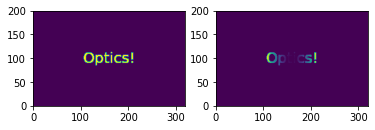

In [301]:
# center the text image on a mask of zeros. add or subtract 1 from the last x or y index if you get a broadcast error
mask = zeros((ymax,xmax))
mask[ymax//2 - dimy//2:ymax//2 + dimy//2, xmax//2 - dimx//2:xmax//2 + dimx//2] = 1-text_img

## physics and system params
lmbda = 5.32e-4*mm
k = 2*pi/lmbda
wx = int(xmax+0.5) # grid width
wy = int(ymax+0.5) 
xpts = linspace(-wx/2,wx/2,mask.shape[1])
ypts = linspace(-wy/2,wy/2,mask.shape[0])
xx,yy = meshgrid(xpts,ypts)
rr = sqrt(xx**2 + yy**2)
phi = arctan2(yy,xx)

output = zeros(mask.shape)

# diffractive element phase profile. 
z = 1000*mm
mask_angl = k*sqrt(xx**2 + yy**2)**2/z  # phase factor for Fresnel propagation over a distance z in free space.

# desired amplitude at sample
desampl = mask

# desired phase map; this is not really important for my design plans
desangl = desampl*mask_angl

fig, axes = plt.subplots(nrows=1,ncols=2)
for ax in axes:
    ax.set_xlim((0,xmax))
    ax.set_ylim((0,ymax))
axes[0].imshow(desampl) # time-average at sample
axes[1].imshow(desangl) # phase map at sample

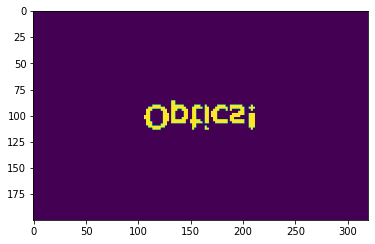

In [246]:
lr = lowres(desampl, div=2, xform=lambda x: (mean(x) + 0.5).astype(int))
fig,ax = plt.subplots()
ax.imshow(lr)

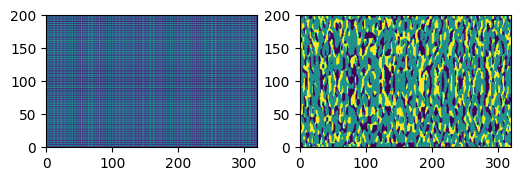

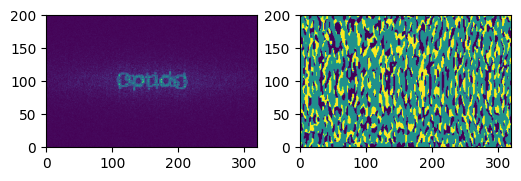

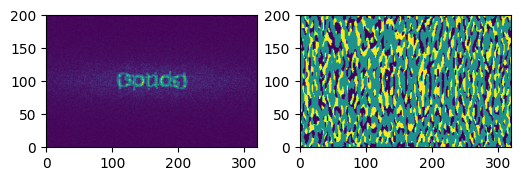

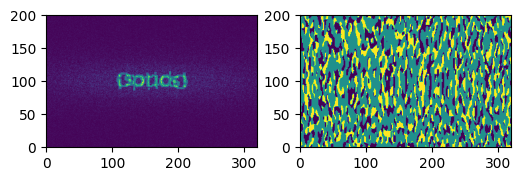

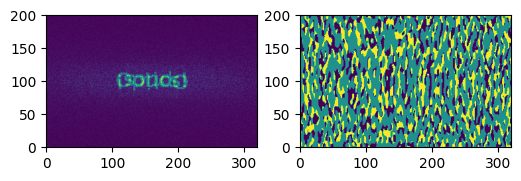

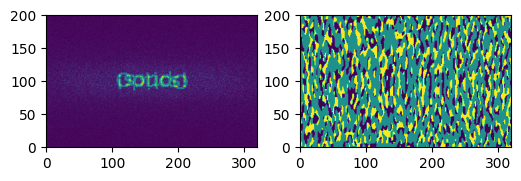

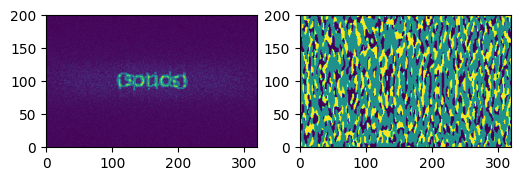

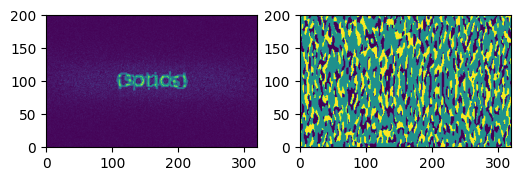

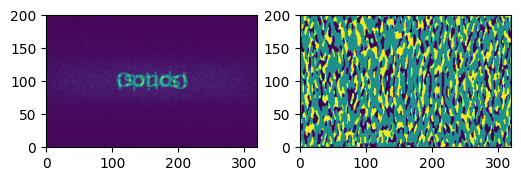

In [303]:
# now, use a binary phase mask o_O... 
# trinary mask produces an intelligible result which looks like the image overlayed on its transpose, 
# but the binary mask forces the amplitude to go to zero. think more about what is going on.

binary = True

# redeclare the mask here so we don't have to rerun everything:
desampl = mask
mask_angl = k*sqrt(xx**2 + yy**2)**2/z  # phase factor for Fresnel propagation over a distance z in free space.
desangl = desampl*mask_angl

# iterate to get a good phase mask
refine = 9

for i in range(refine):
       
    # propagate wave to output
    output = fftshift(fft2(ifftshift(exp(1j*mask_angl))))

    # amplitude of output
    ampl = abs(output)

    # phase of wave arriving at output 
    angl = angle(output)      

    # assign desired amplitude to wave at output
    desout = desampl*exp(1j*angl)

    # back-propagate corrected output profile to mask_angl
    if binary:
        mask_angl = lowres(angle(ifftshift(ifft2(fftshift(desout)))),
                           div=1, 
                           xform=lambda x: pi*(mean(x)+sign(x)*0.5).astype(int) # trinary mask
#                            xform=lambda x: pi*(2*(mean(x+1)/2+sign(x)*0.5).astype(int)-1) # binary mask
                          )
    else:
        mask_angl = angle(ifftshift(ifft2(fftshift(desout))))
        
    if refine < 10:
        fig, axes = plt.subplots(nrows=1,ncols=2,dpi=100)
        for ax in axes:
            ax.set_xlim((0,xmax))
            ax.set_ylim((0,ymax))
        ampl /= amax(ampl)
        cbar0 = axes[0].imshow(ampl) # time-average at output
    #     cbar1 = axes[1].imshow(angl) # phase map at output
        cbar2 = axes[1].imshow(mask_angl) # mask_angl phase map

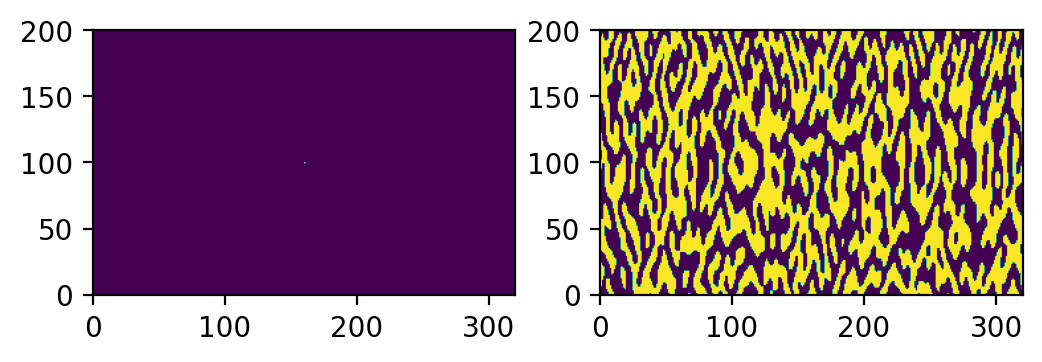

In [296]:
fig, axes = plt.subplots(nrows=1,ncols=2,dpi=200)
for ax in axes:
    ax.set_xlim((0,xmax))
    ax.set_ylim((0,ymax))
ampl /= amax(ampl)
cbar0 = axes[0].imshow(ampl) # time-average at output
# cbar1 = axes[1].imshow(angl) # phase map at output
cbar2 = axes[1].imshow(mask_angl) # mask_angl phase map
# fig.colorbar(cbar2)

In [235]:
ym,xm=mask_angl.shape
# xm/86.4, ym/54
xm/80, ym/50

(4.0, 4.0)

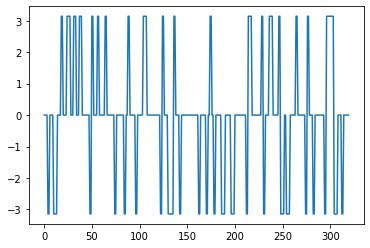

In [279]:
plt.plot(mask_angl[100,])

In [258]:
int(-1.5-0.5)

-2

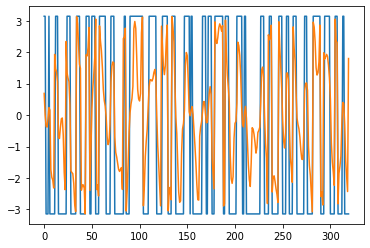

In [283]:
lr = lowres(mask_angl, div=2, xform=lambda x: pi*(2*(mean(x+1)/2+sign(x)*0.5).astype(int)-1))
# lr = lowres(mask_angl, div=5, xform=lambda x: mean(x) + 0.5)
plt.plot(lr[100,])
plt.plot(mask_angl[100,])

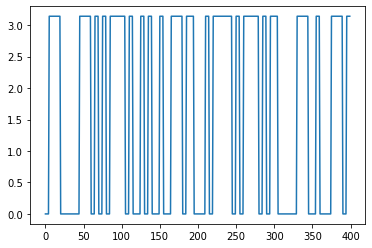

In [189]:
lr = lowres(mask_angl, div=5, xform=lambda x: pi*(mean(x)+0.5).astype(int))
# lr = lowres(mask_angl, div=5, xform=lambda x: mean(x) + 0.5)
plt.plot(lr[100,])

In [130]:
onecount = [[x for x in y if x == 1] for y in ampl]
sum([sum(x) for x in onecount])

1.0

In [110]:
[type(x) for x in ampl[0]

[numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.float64,
 numpy.f

In [120]:
list(ampl[0])[0]

0.00023890377297315732

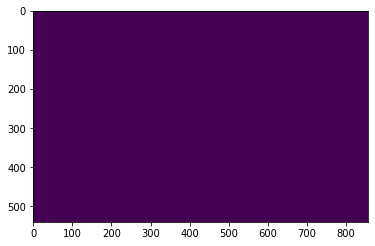

In [85]:
# check the difference from the desired output
plt.imshow(abs(output) - desampl)